In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)

In [31]:
# パラメーター
N_CLASSES = 3  # クラス数
N_INPUTS = 1  # 1ステップに入力されるデータ数
N_STEPS = 200  # 学習ステップ数
LEN_SEQ = 10  # 系列長
N_NODES = 64  # ノード数
N_DATA = 1000  # 各クラスの学習用データ数
N_TEST = 1000  # テスト用データ数
BATCH_SIZE = 20  # バッチサイズ

# データの準備
def gen_non_pulse(len_seq):
    """波を持たない系列データを生成する"""
    ret = np.random.rand(len_seq)
    ret = np.append(ret, 0)
    return ret.reshape(-1,1)

def gen_pulse(len_seq, positive=True):
    """波を持つ系列データを生成する"""
    seq = np.zeros(len_seq)
    i = random.randint(0, len_seq-3)  # 波を立てる位置
    w = random.randint(1, 4)
    w = w if positive else w * (-1.)
    e = 3 if positive else -3
    l = 1 if positive else 2  # ラベル
    seq[i], seq[i+1], seq[i+2] = w, w+e, w
    noise = np.random.rand(len_seq)
    ret = seq + noise
    ret = np.append(ret, l)  # ラベルを加える
    return ret.reshape(-1,1)

def gen_dataset(len_seq, n_data):
    class_01_data = [gen_non_pulse(len_seq) for _ in range(n_data)]
    class_02_data = [gen_pulse(len_seq, positive=True) for _ in range(n_data)]
    class_03_data = [gen_pulse(len_seq, positive=False) for _ in range(n_data)]
    dataset = np.r_[class_01_data, class_02_data, class_03_data]
    np.random.shuffle(dataset)
    x_ = dataset[:,:10]
    t_ = dataset[:,10].reshape(-1)
    return x_, t_

x_train, y_train = gen_dataset(LEN_SEQ, N_DATA)  # 学習用データセット
x_test, y_test = gen_dataset(LEN_SEQ, N_DATA)  # テスト用データセット

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
x_test  = torch.tensor(x_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.int64)

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, l=None):
        x, h = self.lstm(x, h0)
        # 最後のステップのみ取り出す
        # xは(batch_size, step_size, hidden_dim)
        # -> (batch_size, 1)
        if l is not None:
            # 入力のもともとの長さがある場合はそれを使用する
            x = x[list(range(len(x))), l-1, :]
        else:
            # なければ単純に最後を使用する
            x = x[:, -1, :]
        # 取り出した最後のステップを線形層に入れる
        x = self.linear(x)
        # 余分な次元を削除する
        # (batch_size, 1) -> (batch_size, )
        x = x.squeeze()
        return x

In [34]:
def eval_net(net, data_loader, device='cpu'):
    net.eval()
    yans = []
    ypreds = []
    for x,y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            # torch.maxは集計軸を指定すると最大値の他にその値も返す
            # 確率が最大であるラベルをy_predとする．
            _, y_pred = torch.max(net(x), 1)
            yans.append(y)
            ypreds.append(y_pred)
        yans = torch.cat(yans)
        ypreds = torch.cat(ypreds)
        acc = (yans == ypreds).float().sum() / len(yans)
        return acc.item()

 46%|████▌     | 43/94 [00:00<00:00, 429.73it/s]

0.7717799227288429 0.96875 0.90625


 41%|████▏     | 39/94 [00:00<00:00, 389.11it/s]

0.44219891594207666 0.96875 1.0


 43%|████▎     | 40/94 [00:00<00:00, 389.46it/s]

0.3045444365934277 1.0 1.0


 38%|███▊      | 36/94 [00:00<00:00, 353.54it/s]

0.23184418167666274 1.0 1.0


 40%|████      | 38/94 [00:00<00:00, 374.92it/s]

0.18713938893671048 1.0 1.0


 37%|███▋      | 35/94 [00:00<00:00, 341.48it/s]

0.1568676339497902 1.0 1.0


 36%|███▌      | 34/94 [00:00<00:00, 335.67it/s]

0.1350158400784776 1.0 1.0


 37%|███▋      | 35/94 [00:00<00:00, 343.48it/s]

0.1185141803515317 1.0 1.0


 40%|████      | 38/94 [00:00<00:00, 371.64it/s]

0.10560898951887225 1.0 1.0


100%|██████████| 94/94 [00:00<00:00, 352.87it/s]

0.09523967236052565 1.0 1.0


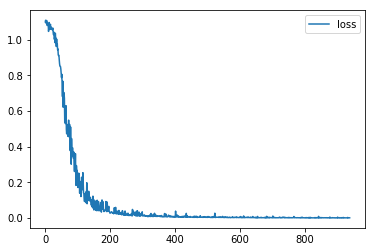

In [35]:
net = LSTM(input_size=1,hidden_size=32,output_size=3,num_layers=1)
net.to('cuda:0')
opt = optim.Adam(net.parameters())
loss_fn = nn.CrossEntropyLoss()

losses = []
for epoch in range(10):
    net.train()
    for x,y in tqdm.tqdm(train_loader):
        x = x.to('cuda:0')
        y = y.to('cuda:0')
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        net.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
    train_acc = eval_net(net, train_loader, 'cuda:0')
    val_acc = eval_net(net, test_loader, 'cuda:0')
    print(np.mean(losses), train_acc, val_acc)
    
plt.plot(losses, label='loss')
plt.legend()